# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = r"./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        #self.word2id = dict.fromkeys(self.word2vec.keys())
        self.word2id = {item:i for i, item in enumerate(self.word2vec.keys())}
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        if type(w)==str:
            similar = [self.score(self.word2vec[w], self.word2vec[self.id2word[i]]) for i in range(len(self.word2id))]
        else:
            similar = [self.score(w, self.word2vec[self.id2word[i]]) for i in range(len(self.word2id))]
        closest = np.argsort(similar)[::-1][:K]
        results = [self.id2word[i] for i in closest]
        return results

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        if type(w1)==str:
            emb1 = self.word2vec[w1]
            emb2 = self.word2vec[w2]
        else:
            emb1 = w1
            emb2 = w2
        
        score = np.dot(emb1, emb2)  / (np.linalg.norm(emb1)*np.linalg.norm(emb2))
        return score
        


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=250000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cat', 'cats', 'kitty', 'kitten', 'feline']
['dog', 'dogs', 'puppy', 'Dog', 'doggie']
['dogs', 'dog', 'pooches', 'Dogs', 'doggies']
['paris', 'france', 'Paris', 'parisian', 'london']
['germany', 'austria', 'europe', 'german', 'berlin']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        idf_dic=idf
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_of_embeddings = [self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_of_embeddings)!=0:
                    sentemb.append(np.mean(list_of_embeddings, axis=0))
                    
                else:
                    #no word is in the lookup table
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))
                   
                #assert False, 'TODO: fill in the blank'
            else:
                # idf-weighted mean of word vectors
                list_of_embeddings = [idf_dic[w]*self.w2v.word2vec[w] for w in sent if w in w2v.word2vec]
                if len(list_of_embeddings)!=0: 
                    sentemb.append(np.mean(list_of_embeddings, axis=0))
                else:
                    #no word is in the lookup table
                    sentemb.append(np.zeros(list(self.w2v.word2vec.values())[0].shape))

                   
                #assert False, 'TODO: fill in the blank'
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        scores = np.dot(keys, query.T)
        scores /= np.reshape(np.linalg.norm(keys, axis=1), (-1,1))
        index_similar_sent = list(np.argsort(scores[:,0])[::-1][:K])
        
        set_sent = []
        print('%s most similar of "%s" are \n' % (K, ' '.join(s)))
        if max(scores)>0:
            for i,ind in enumerate(index_similar_sent):
                print('%s) %s' % (i + 1, ' '.join(sentences[ind])))
                set_sent.append(sentences[ind])
        else: 
            print ('The input sentence do not have wordsof the pretrained vocabulary')
        return set_sent

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        emb1 = self.encode([s1], idf)
        emb2 = self.encode([s2], idf)
        if ((np.linalg.norm(emb1)!=0) and ((np.linalg.norm(emb2)!=0))):
            return emb1.dot(emb2.T)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
        else: 
            return 0
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1        
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
        return idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA,'sentences.txt')) as fichier:
    sentences = fichier.readlines()

sentences = [sent.split() for sent in sentences]

# Build idf scores for each word
idf = {} if False else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))
print('\n\n')

#idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 10000 pretrained word vectors
5 most similar of "1 smiling african american boy ." are 

1) 1 smiling african american boy .
2) girl smiling on roller coaster .
3) a boy smiles underwater .
4) two girlfriends smiling .
5) a smiling child swims .
[[0.59360354]]



5 most similar of "1 smiling african american boy ." are 

1) 1 smiling african american boy .
2) 5 women and 1 man are smiling for the camera .
3) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on .
4) two girlfriends smiling .
5) 1 man singing and 1 man playing a saxophone in a concert .
[[0.50048646]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)



Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
intersect = [w for w in w2v_fr.word2vec if w in w2v_en.word2vec]
X = np.vstack([w2v_en.word2vec[w] for w in intersect])
Y = np.vstack([w2v_fr.word2vec[w] for w in intersect])
print(len(intersect))

18970


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE

import scipy.linalg as la

def build_alignement(w2v_lang_1,w2v_lang_2):
    #Solve the Procrustes probelm from language 1 to language 2 and give the optimal alinement matrix
    intersect = [w for w in w2v_lang_1.word2vec if w in w2v_lang_2.word2vec]
    X = np.vstack([w2v_lang_1.word2vec[w] for w in intersect]).T
    Y = np.vstack([w2v_lang_2.word2vec[w] for w in intersect]).T
    U, s, Vh = la.svd(Y.dot(X.T))
    return U.dot(Vh)

W = build_alignement(w2v_fr,w2v_en) 
W_inv = np.linalg.inv(W)

In [13]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

print('From French to English')

for w in ['fort','chat','manger','chien','toit', 'après']:
    emb = np.dot(W, w2v_fr.word2vec[w])
    print('Most similar words for %s are : ' %  w, str(w2v_en.most_similar(emb)))
    
print('\n')

print('From English to French')
for w in [ 'real', 'learning','dog' ,'feeling', 'tedious', 'actually']:
    emb = np.dot(W_inv, w2v_en.word2vec[w])
    print('Most similar words for %s are : ' % w, str(w2v_fr.most_similar(emb)) )


From French to English
Most similar words for fort are :  ['fort', 'forts', 'fortification', 'blockhouse', 'fortifications']
Most similar words for chat are :  ['cat', 'rabbit', 'hamster', 'feline', 'poodle']
Most similar words for manger are :  ['eat', 'meal', 'eating', 'eaten', 'ate']
Most similar words for chien are :  ['dog', 'poodle', 'terrier', 'dogs', 'spaniel']
Most similar words for toit are :  ['roof', 'roofed', 'roofs', 'mansard', 'balconies']
Most similar words for après are :  ['after', 'shortly', 'afterward', 'afterwards', 'ensuing']


From English to French
Most similar words for real are :  ['real', 'reality', 'personal', 'réel', 'property']
Most similar words for learning are :  ['learning', 'education', 'apprentissage', 'apprentissages', 'educational']
Most similar words for dog are :  ['dog', 'chien', 'hound', 'chiens', 'chienne']
Most similar words for feeling are :  ['sentiment', 'feeling', 'mélancolie', 'sentiments', 'frustration']
Most similar words for tedious a

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [13]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def read(file_path,test=False):
    #This function allows to read the SST training file
    with open(file_path,'r') as f:
        lines = f.readlines()
    if test:
        return([line.split() for line in lines])
    else :
        #each line is composed of y_train , x_train
        return([line.split()[1:] for line in lines],[int(line.split()[0]) for line in lines])


x_train,y_train = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'),test=True)

In [14]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=250000)
s2v = BoV(w2v)

sentences = x_train  + x_dev + x_test
idf = {} if False else s2v.build_idf(sentences)

x_train_encode = s2v.encode(x_train)

x_dev_encode = s2v.encode(x_dev)

x_test_encode = s2v.encode(x_test)

x_train_encode_idf = s2v.encode(x_train,idf)

x_dev_encode_idf = s2v.encode(x_dev,idf)

x_test_encode_idf = s2v.encode(x_test,idf)

Loaded 250000 pretrained word vectors


In [15]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)


# TYPE CODE HERE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

scaler1 = preprocessing.StandardScaler().fit(x_train_encode)
normalized_encoded_train_data = scaler1.transform(x_train_encode)
normalized_encoded_valid_data = scaler1.transform(x_dev_encode)


scaler2 = preprocessing.StandardScaler().fit(x_train_encode_idf)
normalized_encoded_train_data_weighted = scaler2.transform(x_train_encode_idf)
normalized_encoded_valid_data_weighted = scaler2.transform(x_dev_encode_idf)

#without idf
clf = LogisticRegression(penalty='l2', C=0.01,tol=1e-6)
clf.fit(normalized_encoded_train_data,y_train)
y_dev_predict = clf.predict(normalized_encoded_valid_data)
y_train_predict = clf.predict(normalized_encoded_train_data)
print ('train set without idf precision', accuracy_score(y_train,y_train_predict))
print ('dev set without idf precision', accuracy_score(y_dev,y_dev_predict))

#with idf
clf_idf = LogisticRegression(penalty='l2', C=0.01,tol=1e-6)
clf_idf.fit(normalized_encoded_train_data_weighted,y_train)
y_dev_predict_idf = clf_idf.predict(normalized_encoded_valid_data_weighted)
y_train_predict_idf = clf_idf.predict(normalized_encoded_train_data_weighted)


print ('train set with idf precision', accuracy_score(y_train,y_train_predict_idf))
print ('dev set with idf precision', accuracy_score(y_dev,y_dev_predict_idf))


train set without idf precision 0.48408239700374533
dev set without idf precision 0.407811080835604
train set with idf precision 0.47120786516853935
dev set with idf precision 0.4014532243415077


In [16]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

prediction= clf.predict(x_test_encode)
lines = '\n'.join([str(line) for line in prediction])
path_output = os.path.join('.',r'logreg_bov_y_test_sst.txt')
with open(path_output,'w') as f:
        f.writelines(lines)


In [18]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier


#I tried many classifiers and random forests seems to be the best one 
print('LGBMC')

lgb = LGBMClassifier(max_depth=5,n_estimators=300,reg_lambda=0.01) #with early stopping based on val set

lgb.fit(x_train_encode,y_train,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(x_train_encode,y_train),(x_dev_encode,y_dev)]) 
y_dev_predict = lgb.predict(x_dev_encode)
y_train_predict = lgb.predict(x_train_encode)

print ('  train set without idf precision', accuracy_score(y_train,y_train_predict))
print ('  dev set without idf precision', accuracy_score(y_dev,y_dev_predict))

       
lgb_idf = LGBMClassifier(max_depth=5,n_estimators=300,reg_lambda=0.01) #with early stopping based on val set

lgb_idf.fit(x_train_encode_idf,y_train,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(x_train_encode_idf,y_train),(x_dev_encode_idf,y_dev)])
y_dev_predict_idf = lgb_idf.predict(x_dev_encode_idf)
y_train_predict_idf = lgb_idf.predict(x_train_encode_idf)
    
print ('  train set with idf precision', accuracy_score(y_train,y_train_predict_idf))
print ('  dev set with idf precision', accuracy_score(y_dev,y_dev_predict_idf))

prediction= rf.predict(x_test_encode)
lines = '\n'.join([str(line) for line in prediction])
path_output = os.path.join('.',r'lgb_bov_y_test_sst.txt')
with open(path_output,'w') as f:
        f.writelines(lines)


LGBMC


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


  train set without idf precision 0.9774110486891385
  dev set without idf precision 0.4069028156221617


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


  train set with idf precision 0.9465121722846442
  dev set with idf precision 0.36966394187102636


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [41]:
import keras

In [43]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = r"./data/"

# TYPE CODE HERE
x_train,y_train_temp = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'),test=True)

In [44]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing import text
from keras.utils import to_categorical
vocab=np.ravel(np.array(x_train+x_dev+x_test))
n=len(vocab)


x_train_one_hot = [text.one_hot(' '.join(x),n) for x in x_train]
x_dev_one_hot = [text.one_hot(' '.join(x),n) for x in x_dev]
x_test_one_hot = [text.one_hot(' '.join(x),n) for x in x_test]


y_train = to_categorical(y_train_temp)
y_val = to_categorical(y_dev)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [50]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

n_train=len(x_train_one_hot)
n_val=len(x_dev_one_hot)
pad=pad_sequences(x_train_one_hot+x_dev_one_hot+x_test_one_hot)
x_train_pad=pad[:n_train,:]
x_val_pad=pad[n_train:n_train+n_val,:]
x_test_pad=pad[n_train+n_val:,:]
maxseqlen = pad.shape[1]


## 4.2 - Design and train your model

In [57]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = list(w2v_en.word2vec.values())[0].shape[0] #300  # word embedding dimension
nhid       = 96  # number of hidden units in the LSTM
vocab_size = n  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(96, dropout=0.2, recurrent_dropout=0.2)`


In [58]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras import optimizers

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 300)         3556500   
_________________________________________________________________
lstm_9 (LSTM)                (None, 96)                152448    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 485       
Total params: 3,709,433
Trainable params: 3,709,433
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 41s 5ms/step - loss: 1.4875 - acc: 0.3385 - val_loss: 1.3790 - val_acc: 0.3860
Epoch 2/6
8544/8544 [==============================] - 37s 4ms/step - loss: 1.1501 - acc: 0.4950 - val_loss: 1.4348 - val_acc: 0.4087
Epoch 3/6
8544/8544 [==============================] - 37s 4ms/step - loss: 0.7951 - acc: 0.6879 - val_loss: 1.7132 - val_acc: 0.3733
Epoch 4/6
8544/8544 [==============================] - 37s 4ms/step - loss: 0.4915 - acc: 0.8159 - val_loss: 2.1568 - val_acc: 0.3678
Epoch 5/6
8544/8544 [==============================] - 37s 4ms/step - loss: 0.2946 - acc: 0.8943 - val_loss: 2.5684 - val_acc: 0.3579
Epoch 6/6
8544/8544 [==============================] - 37s 4ms/step - loss: 0.1696 - acc: 0.9393 - val_loss: 3.0256 - val_acc: 0.3669


<Figure size 432x288 with 0 Axes>

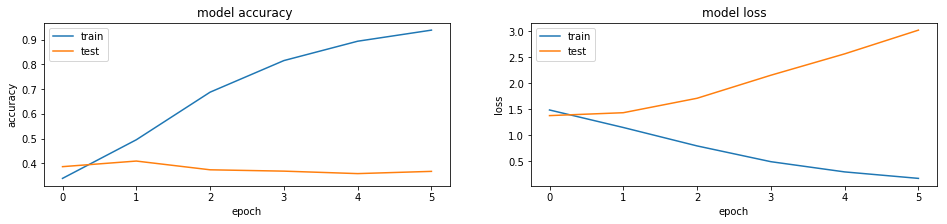

In [59]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
from keras.callbacks import ModelCheckpoint

bs = 64
n_epochs = 6



def plot_acc_loss(history):
    plt.figure(1)  
    plt.figure(figsize=(16,3))
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy ' )
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
   
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
mcp1 = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)
history = model.fit(x_train_pad, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val_pad, y_val), callbacks = [mcp1])
plot_acc_loss(history)

In [60]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
model = keras.models.load_model('weights.best.hdf5') 
y_test_one_hot = model.predict(x_test_pad)
y_test_predict = [np.argmax(y) for y in y_test_one_hot]

path_output = os.path.join('.',r'logreg_lstm_y_test_sst.txt')
lines = '\n'.join([str(line) for line in y_test_predict])
with open(path_output,'w') as f:
    f.writelines(lines)



## 4.3 -- innovate !

In [72]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation,Dropout,Conv1D,Flatten, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Bidirectional 
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import text
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = r"./data/"


x_train,y_train_temp = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.train'))
x_dev,y_dev_temp = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.dev'))
x_test = read(os.path.join(PATH_TO_DATA,'SST','stsa.fine.test.X'),test=True)

vocab=np.ravel(np.array(x_train+x_dev+x_test))
n=len(vocab)

# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
x_train_one_hot = [text.one_hot(' '.join(x),n) for x in x_train]
x_dev_one_hot = [text.one_hot(' '.join(x),n) for x in x_dev]
x_test_one_hot = [text.one_hot(' '.join(x),n) for x in x_test]

y_train = to_categorical(y_train_temp)
y_val = to_categorical(y_dev_temp)



# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
n_train=len(x_train_one_hot)
n_val=len(x_dev_one_hot)
pad=pad_sequences(x_train_one_hot+x_dev_one_hot+x_test_one_hot)
x_train_pad=pad[:n_train,:]
x_val_pad=pad[n_train:n_train+n_val,:]
x_test_pad=pad[n_train+n_val:,:]
maxseqlen = pad.shape[1]

# 4 - Design your encoder + classifier using keras.layers
embed_dim  = 300  # word embedding dimension
vocab_size = n # size of the vocabulary
n_classes  = 5

list_w = set([w for sent in (x_train+x_dev+x_test) for w in sent ])
embedding_matrix = np.zeros((vocab_size, embed_dim))
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000000)
for w in list_w:
    if w in w2v.word2vec:
        embedding_matrix[text.one_hot(' '.join(w),vocab_size)] = w2v.word2vec[w]


mcp1 = ModelCheckpoint('weights.best_innovate.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

model = Sequential()
model.add(Embedding(vocab_size,embed_dim,input_length=maxseqlen,weights=[embedding_matrix]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(96,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


#model = Sequential()
#model.add(Embedding(vocab_size,embed_dim,weights=[embedding_matrix]))
#model.add(Conv1D(64, 3, activation='relu', input_shape=(vocab_size, embed_dim)))
#model.add(Conv1D(64, 3, activation='relu'))
#model.add(MaxPooling1D(3))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(Conv1D(128, 3, activation='relu'))
#model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])

print(model.summary())
bs = 64
n_epochs = 8


history = model.fit((x_train_pad), y_train, batch_size=bs, epochs=n_epochs, validation_data=((x_val_pad), y_val),callbacks = [mcp1])

y_test_one_hot = model.predict(x_test_pad)
y_test_predict = [np.argmax(y) for y in y_test_one_hot]

path_output = os.path.join('.',r'conv1d_y_test_sst.txt')
lines = '\n'.join([str(line) for line in y_test_predict])
with open(path_output,'w') as f:
    f.writelines(lines)

Loaded 200000 pretrained word vectors
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 52, 300)           3556500   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 52, 32)            28832     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 26, 32)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 96)                49536     
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 485       
Total params: 3,635,353
Trainable params: 3,635,353
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [====================